## Mex Local Rates systematic signals
I am going to explore, which way of constructing the interest rate butterfly produces best trade for mean-reversion strategy with Mexican MBONOs market as a example. I am going to utilise history of fitted zero-coupon curves that I estimated from 12 years of cash bond prices. And construct a dynamic portfolio of bonds for desired target risk profile.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import QuantLib as ql
import statsmodels.api as sm
import sqlite3

from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from math import log, sqrt
from termcolor import cprint

from signals import MeanReversionSignal, AggregatedSignal
from strategies import SystematicStrategy

plt.style.use('ggplot')

Below are few auxiliary procedures

In [7]:
#Fubnction for estimating buttefly weights based on PCA of zero curve
def get_pca_bf_weights(zc_data):
    cov = zc_data.cov()
    eig_vals, eig_vecs = np.linalg.eig(cov)
    permutation = np.argsort(-eig_vals)
    eig_vals = eig_vals[permutation]
    eig_vecs = eig_vecs[:, permutation]
    A = eig_vecs.T
    A[2] = [0, 1, 0]
    bf_weights = np.linalg.inv(A) @ np.array([[0], [0], [1]])
    return bf_weights

#Estimating Ornstein-Uhlenbeck parameters
def fit_ou_params(x):
    reg = sm.OLS(x[1:],sm.add_constant(x[:-1])).fit()
    theta = -log(reg.params[1])
    mu = reg.params[0] / (1 - reg.params[1])
    sigma_eq = np.std(reg.resid) / sqrt((1 - reg.params[1] ** 2))
    hl = log(2) / theta
    return theta, mu, sigma_eq, hl

In [18]:
def signal_comparison(signals, signal_types,
                      df_zc, df_instruments, df_prices, df_fit,
                      vol_adjustment=False):
    fig, ax = plt.subplots(4,1, figsize=(20,20), gridspec_kw={'height_ratios': [2, 1, 1, 1]})
    ax[0].title.set_text('Raw signal Performance')
    ax[0].xaxis.set_label_text('Date')
    ax[0].yaxis.set_label_text('DV01 points')
    signal_stats = pd.DataFrame(index=signal_types, columns=['Gross Sharpe', 'Net Sharpe', 'Daily Turnover'])
    for i in range(len(signal_types)):
        aggregated_signal = AggregatedSignal(signals[i], dates=df_zc.loc['2015':].index)
        aggregated_signal.estimate_target_risk()
        if vol_adjustment:
            aggregated_signal.set_target_volatility(1, df_zc)
        pnl = 10000*aggregated_signal.dumb_pnl(df_zc.loc['2015':])
        ax[0].plot(pnl.cumsum())
        strategy = SystematicStrategy(aggregated_signal, df_instruments, df_prices, df_zc, fit_resid=df_fit)
        strategy.calc_position()
        strategy.calc_total_pnl()
        signal_stats.loc[signal_types[i], 'Gross Sharpe'] = np.sqrt(261) * strategy.pnl.sum(axis=1).mean() / \
            strategy.pnl.sum(axis=1).std()
        ax[i+1].plot(strategy.pnl.sum(axis=1).cumsum())
        strategy.calc_total_pnl(0.00005)
        ax[i+1].plot(strategy.pnl.sum(axis=1).cumsum())
        ax[i+1].title.set_text(signal_types[i] + ' strategy PnL')
        ax[i+1].xaxis.set_label_text('Date')
        ax[i+1].yaxis.set_label_text('PnL, $')
        ax[i+1].legend(['Gross', 'Net'])
        signal_stats.loc[signal_types[i], 'Net Sharpe'] = np.sqrt(261) * strategy.pnl.sum(axis=1).mean() / \
            strategy.pnl.sum(axis=1).std()
        turnover = (strategy.trades * strategy.dirty_prices).abs().sum(axis=1).sum() / \
            (strategy.position * strategy.dirty_prices).abs().sum(axis=1).sum()
        signal_stats.loc[signal_types[i], 'Daily Turnover'] = turnover
    ax[0].legend(signal_types, loc='best')
    plt.show()
    return signal_stats

Setting MBONO market conventions

In [9]:
CONVENTION = ql.Unadjusted
CALENDAR = ql.Mexico()
YIELD_BASIS = ql.Semiannual
TENOR = ql.Period(ql.Semiannual)
RULE = ql.DateGeneration.Backward
DAY_COUNT = ql.Actual360()
SETTLEMENT_DAYS = 2

Loading all the neccesarry data: zero curves, instruments, prices etc

Source of fitted curves and estimation: https://github.com/akaufman22/mbono-firv

In [10]:
#Function for defining QuantLib bonds from a list of instrument ids
def define_ql_bonds_bulk(instrument_ids, id_type='BBGID'):
    con = sqlite3.connect("./db/MBONOdata.db")
    str_ids = '('+str(instrument_ids)[1:-1]+')'
    bonds_sample = []
    query = """SELECT Instruments.%s, StaticSchedules.Date,
    StaticSchedules.Coupon, StaticSchedules.Principal
    FROM StaticSchedules INNER JOIN Instruments
    ON StaticSchedules.InstrumentID = Instruments.InstrumentID
    WHERE Instruments.%s in %s;""" % (id_type, id_type, str_ids)
    aggregate_schedules = pd.read_sql_query(query, con, parse_dates=['Date'])
    for b in instrument_ids:
        bond_schedule = aggregate_schedules[
            aggregate_schedules[id_type] == b].copy().sort_values('Date')
        bond_schedule['Days'] = (bond_schedule['Date'] -
                                 bond_schedule['Date'].shift(1)).dt.days
        schedule = ql.Schedule(bond_schedule['Date'].apply(
            ql.Date().from_date).values, CALENDAR,
                           CONVENTION, CONVENTION, TENOR, RULE, False)
        face_value = sum(bond_schedule['Principal'])
        coupons = ((360 / bond_schedule['Days']) * bond_schedule['Coupon'] /
                   face_value).dropna().values
        bonds_sample.append(ql.FixedRateBond(SETTLEMENT_DAYS, 100,
                                             schedule, coupons, DAY_COUNT))
    return bonds_sample

In [11]:
#Precaculated history of zero curve
df_zc = pd.read_csv('ZeroCurve.csv', parse_dates=[0], index_col=0).sort_index()
df_zc.columns = ['Y' + str(i) for i in df_zc.columns]
df_zc.index.name = 'Date'
df_zc.head()

,Y1,Y2,Y3,Y5,Y7,Y10,Y15,Y20,Y30
Date,,,,,,,,,
2010-01-01,0.049139,0.059082,0.066124,0.074606,0.079008,0.082525,0.086468,0.090251,0.096812
2010-01-04,0.048706,0.059136,0.066494,0.075229,0.079574,0.082800,0.086405,0.090291,0.097765
2010-01-05,0.051110,0.058690,0.066621,0.075089,0.079097,0.082451,0.086078,0.089435,0.098320
2010-01-06,0.050152,0.059206,0.066920,0.074806,0.078709,0.082246,0.086287,0.089779,0.097143
2010-01-07,0.048686,0.059434,0.066632,0.074840,0.078968,0.082336,0.086170,0.089791,0.096544


In [12]:
#Loading the instrument unviverse (static data)
con = sqlite3.connect("./db/MBONOdata.db")
query = """SELECT DISTINCT BBGId, InstrumentID, Maturity, PricingDate from Instruments WHERE Maturity > 2010-01-01;"""
df_instruments = pd.read_sql_query(query, con, parse_dates=['PricingDate', 'Maturity'])
bonds = define_ql_bonds_bulk(list(df_instruments['BBGID'].values), id_type='BBGID')
df_instruments['QL bond'] = bonds
df_instruments.set_index('BBGID', inplace=True)
df_instruments.head()

,InstrumentID,Maturity,PricingDate,QL bond
BBGID,,,,
EC4262522 Corp,6,2011-07-14,2001-07-20,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
EC6223613 Corp,10,2009-07-09,2002-07-12,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
EC8045386 Corp,12,2009-12-24,2002-12-27,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
EC8084633 Corp,13,2012-12-20,2003-01-03,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
ED2028832 Corp,15,2023-12-07,2003-10-24,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...


In [13]:
#Loading the market data
query = """SELECT InstrumentID,  Date, Price FROM MarketData ;"""
agg_price_data = pd.read_sql_query(query, con, parse_dates=['Date']).sort_values(['Date'])
df_prices = agg_price_data.pivot_table(index='Date', columns='InstrumentID', values='Price')
df_prices.columns = [df_instruments.index[
    df_instruments['InstrumentID'] == c][0] for c in df_prices.columns]
df_prices.head()

,EC4262522 Corp,EC8045386 Corp,EC8084633 Corp,ED2028832 Corp,ED2746086 Corp,ED2816525 Corp,ED7597518 Corp,ED7791103 Corp,ED7894840 Corp,EF2270975 Corp,...,EK1693424 Corp,EI7361336 Corp,QJ1649335 Corp,AM7523740 Corp,AS2511341 Corp,AX6352725 Corp,ZR8833868 Corp,BR4592233 Corp,BS4948482 Corp,BX4963407 Corp
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,108.040,100.011,106.456,97.457,102.788,103.646,109.157,114.879,106.560,102.930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,108.045,100.011,106.240,97.553,102.804,103.390,108.919,114.605,106.521,102.383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,108.057,100.011,106.251,97.814,102.790,103.383,108.901,114.911,106.493,102.395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,108.099,100.011,106.317,97.862,102.783,103.377,108.945,115.047,106.483,102.438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,108.074,100.011,106.421,97.907,102.771,103.481,109.026,114.992,106.471,102.539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#Loading the spreads to the fitted curve
query = """SELECT InstrumentID,  Date, Residual FROM FitData ;"""
agg_fit_data = pd.read_sql_query(query, con, parse_dates=['Date']).sort_values(['Date'])
df_fit = agg_fit_data.pivot_table(index='Date', columns='InstrumentID', values='Residual')
df_fit.columns = [df_instruments.index[df_instruments['InstrumentID'] == c][0] for c in df_fit.columns]
df_fit.head()

,EC4262522 Corp,EC8084633 Corp,ED2028832 Corp,ED2746086 Corp,ED2816525 Corp,ED7597518 Corp,ED7791103 Corp,ED7894840 Corp,EF2270975 Corp,EF5478096 Corp,...,EK1693424 Corp,EI7361336 Corp,QJ1649335 Corp,AM7523740 Corp,AS2511341 Corp,AX6352725 Corp,ZR8833868 Corp,BR4592233 Corp,BS4948482 Corp,BX4963407 Corp
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,-0.004205,0.000866,0.000246,0.001868,-0.000460,-0.000070,-0.000353,-0.003555,-0.001657,0.001410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,-0.004120,0.001318,-0.000007,0.002118,-0.000227,-0.000095,-0.000196,-0.003388,-0.001114,0.000812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-0.004285,0.001036,-0.000109,-0.000957,-0.000428,-0.000060,-0.000277,-0.003048,-0.000915,0.000322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,-0.004713,0.000510,-0.000162,0.000188,-0.000374,0.000061,-0.000439,-0.003443,-0.000682,0.000156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,-0.004839,0.000492,-0.000138,0.002286,-0.000367,-0.000046,-0.000309,-0.003523,-0.000962,0.000314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I produce signals based on mean-reversion of butterflies. Estimation set is rolling five years lookback period. Test set is rolling one year forward period. Three methods of butterfly weighting are used: baseline duration weighted, weights generated by the Johansen procedure and PCA-based (applied to levels)

In [15]:
tenors = ['Y2', 'Y3', 'Y5', 'Y7', 'Y10', 'Y15', 'Y20']

lookback_years = 5
test_years = 1
p_val_crit = 0.1
hl_crit = 30
sigma_crit = 0.0003
z_ol = -2
z_cl = -.5
z_os = 2
z_cs = .5

eoy = pd.date_range(end=df_zc.index[-1], start = df_zc.index[0], freq='BY')
dv_bf_weights = np.array([-0.5, 1.0, -0.5]).reshape(-1,1)
dv_signals = []
pca_signals = []
jo_signals = []
                
for i in tqdm(range(lookback_years-1, len(eoy), 1)):
    idx = pd.bdate_range(start=eoy[i] + pd.tseries.offsets.DateOffset(years=-lookback_years), end=eoy[i])
    train_idx = df_zc.index.intersection(idx)
    idx = pd.bdate_range(end=eoy[i] + pd.tseries.offsets.DateOffset(years=test_years),
                        start=eoy[i] + pd.tseries.offsets.DateOffset(days=1))
    test_idx = df_zc.index.intersection(idx)
    for j, t1 in enumerate(tenors):
        for k, t2 in enumerate(tenors[j+1:j+2]):
            for t3 in tenors[j+k+2:j+k+3]:
                dv_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(dv_bf_weights)
                if adfuller(dv_bf_ts)[1] < p_val_crit:
                    _, mu, sigma_eq, hl = fit_ou_params(dv_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        dv_bf_test = df_zc.loc[test_idx, [t1, t2, t3]].dot(dv_bf_weights)
                        dv_signal = MeanReversionSignal([t1, t2, t3], dv_bf_weights, dv_bf_test, mu, sigma_eq)
                        dv_signal.set_trading_rule(ol=z_ol, cl=z_cl, os=z_os, cs=z_cs, ts=30)
                        dv_signals.append(dv_signal)
                pca_bf_weights = get_pca_bf_weights(df_zc.loc[train_idx, [t1, t2, t3]])
                pca_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(pca_bf_weights)
                if adfuller(pca_bf_ts)[1] < p_val_crit:
                    _, mu, sigma_eq, hl  = fit_ou_params(pca_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        #print(test_idx[0], t1, t2, t3, int(hl), int(10000*sigma_eq))
                        pca_bf_test = df_zc.loc[test_idx, [t1, t2, t3]].dot(pca_bf_weights)
                        pca_signal = MeanReversionSignal([t1, t2, t3], pca_bf_weights, pca_bf_test, mu, sigma_eq)
                        pca_signal.set_trading_rule(ol=z_ol, cl=z_cl, os=z_os, cs=z_cs, ts=30)
                        pca_signals.append(pca_signal)
                johansen = coint_johansen(df_zc.loc[train_idx, [t1, t2, t3]], det_order=1, k_ar_diff=1)
                if (johansen.lr1[0] > johansen.cvt[0,1]) & (johansen.lr2[0] > johansen.cvm[0,1]):
                    jo_bf_weights = (johansen.evec[:,0] / johansen.evec[1,0]).reshape(-1,1)
                    jo_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(jo_bf_weights)
                    _, mu, sigma_eq, hl  = fit_ou_params(jo_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        jo_bf_test = df_zc.loc[test_idx, [t1, t2, t3]].dot(jo_bf_weights)
                        jo_signal = MeanReversionSignal([t1, t2, t3], jo_bf_weights, jo_bf_test, mu, sigma_eq)
                        jo_signal.set_trading_rule(ol=z_ol, cl=z_cl, os=z_os, cs=z_cs, ts=30)
                        jo_signals.append(jo_signal)


100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


To assess signal quality I do a backtest of three unoptimized trading strategies, each utilising single type of butterfly construction method. Assumptions here are fixed (per unit of risk) transaction cost, zero slippage and cost of funding defined by short-end rate.
First we compare performance when adding signals of same type together:

Simple aggregation of signals
Aggregating Signals
Calculating Position


100%|██████████| 2057/2057 [02:20<00:00, 14.61it/s]


Aggregating Signals
Calculating Position


100%|██████████| 2057/2057 [03:35<00:00,  9.56it/s]


Aggregating Signals
Calculating Position


100%|██████████| 2057/2057 [04:12<00:00,  8.14it/s]


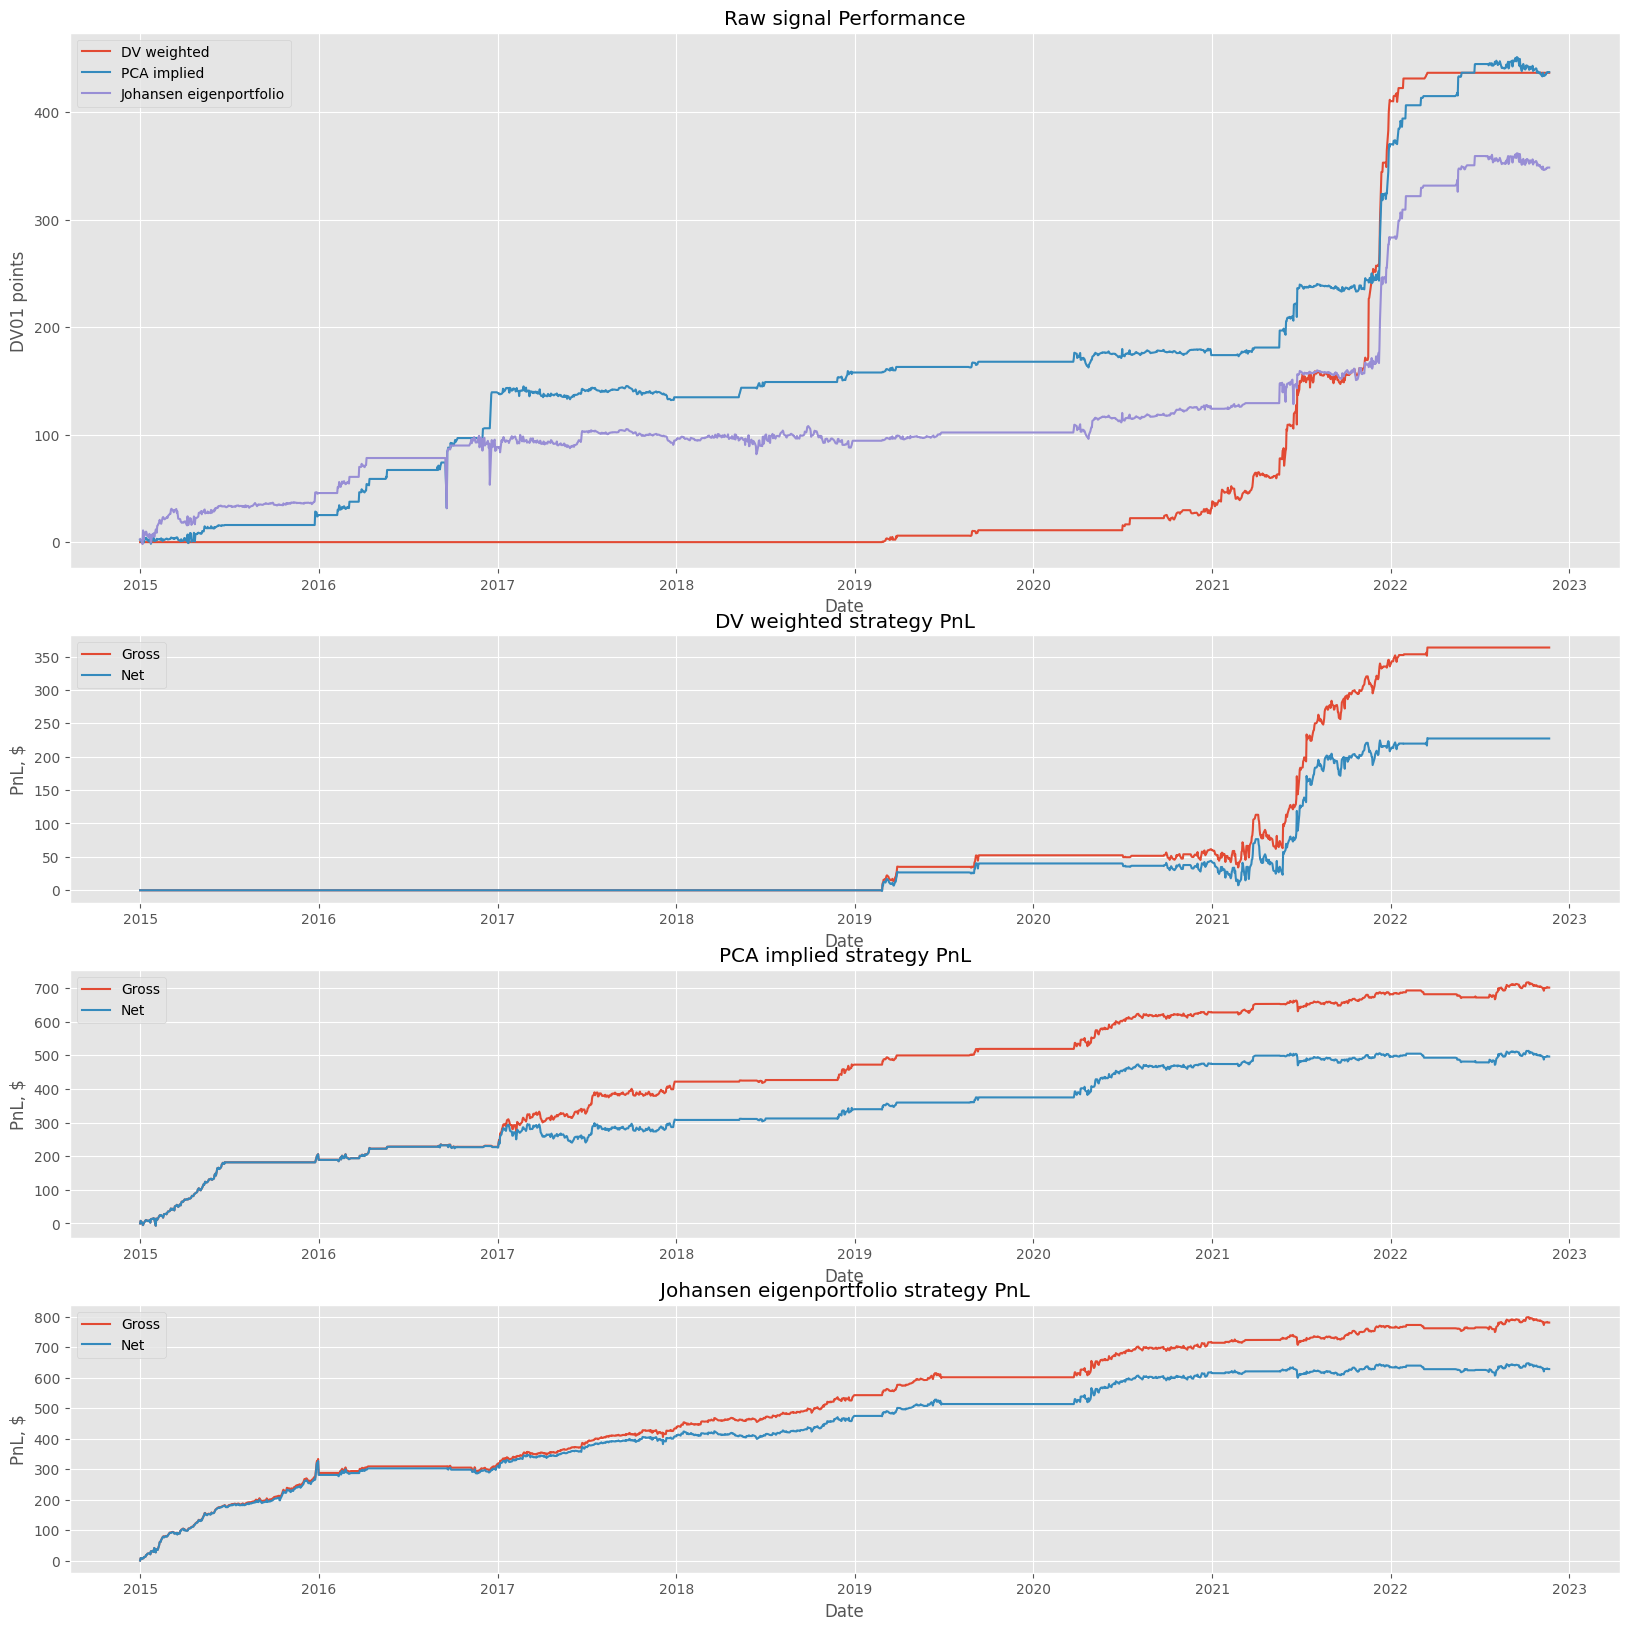

,Gross Sharpe,Net Sharpe,Daily Turnover
DV weighted,1.12,0.72,36.07%
PCA implied,1.83,1.30,44.24%
Johansen eigenportfolio,1.94,1.56,40.58%


In [26]:
signal_types = ['DV weighted', 'PCA implied', 'Johansen eigenportfolio']
signals = [dv_signals, pca_signals, jo_signals]
cprint (('Simple aggregation of signals'.center(24)), 'green', attrs=['bold'])
signal_stats = signal_comparison(signals, signal_types, df_zc, df_instruments, df_prices, df_fit, vol_adjustment=False)
signal_stats.style.format({'Gross Sharpe': '{:.2f}', 'Net Sharpe': '{:.2f}', 'Daily Turnover': '{:.2%}'})

Johansen provides better Sharpe while also not highest turnover. However, above is not exactly apple-to-apple comparison. Also, this strategy produces very variable risk profile and probabaly inconsistant with risk limits and the neccessity to deploy capital.

Much more realistic case of strategies based on constant signal volatility:

Aggregation of signals with volatility adjustment
Aggregating Signals
Setting Target Volatility


100%|██████████| 2058/2058 [00:19<00:00, 106.95it/s]


Calculating Position


100%|██████████| 2057/2057 [04:17<00:00,  7.99it/s]


Aggregating Signals
Setting Target Volatility


100%|██████████| 2058/2058 [00:27<00:00, 73.81it/s] 


Calculating Position


100%|██████████| 2057/2057 [04:39<00:00,  7.37it/s]


Aggregating Signals
Setting Target Volatility


100%|██████████| 2058/2058 [00:15<00:00, 135.05it/s]


Calculating Position


100%|██████████| 2057/2057 [04:47<00:00,  7.15it/s]


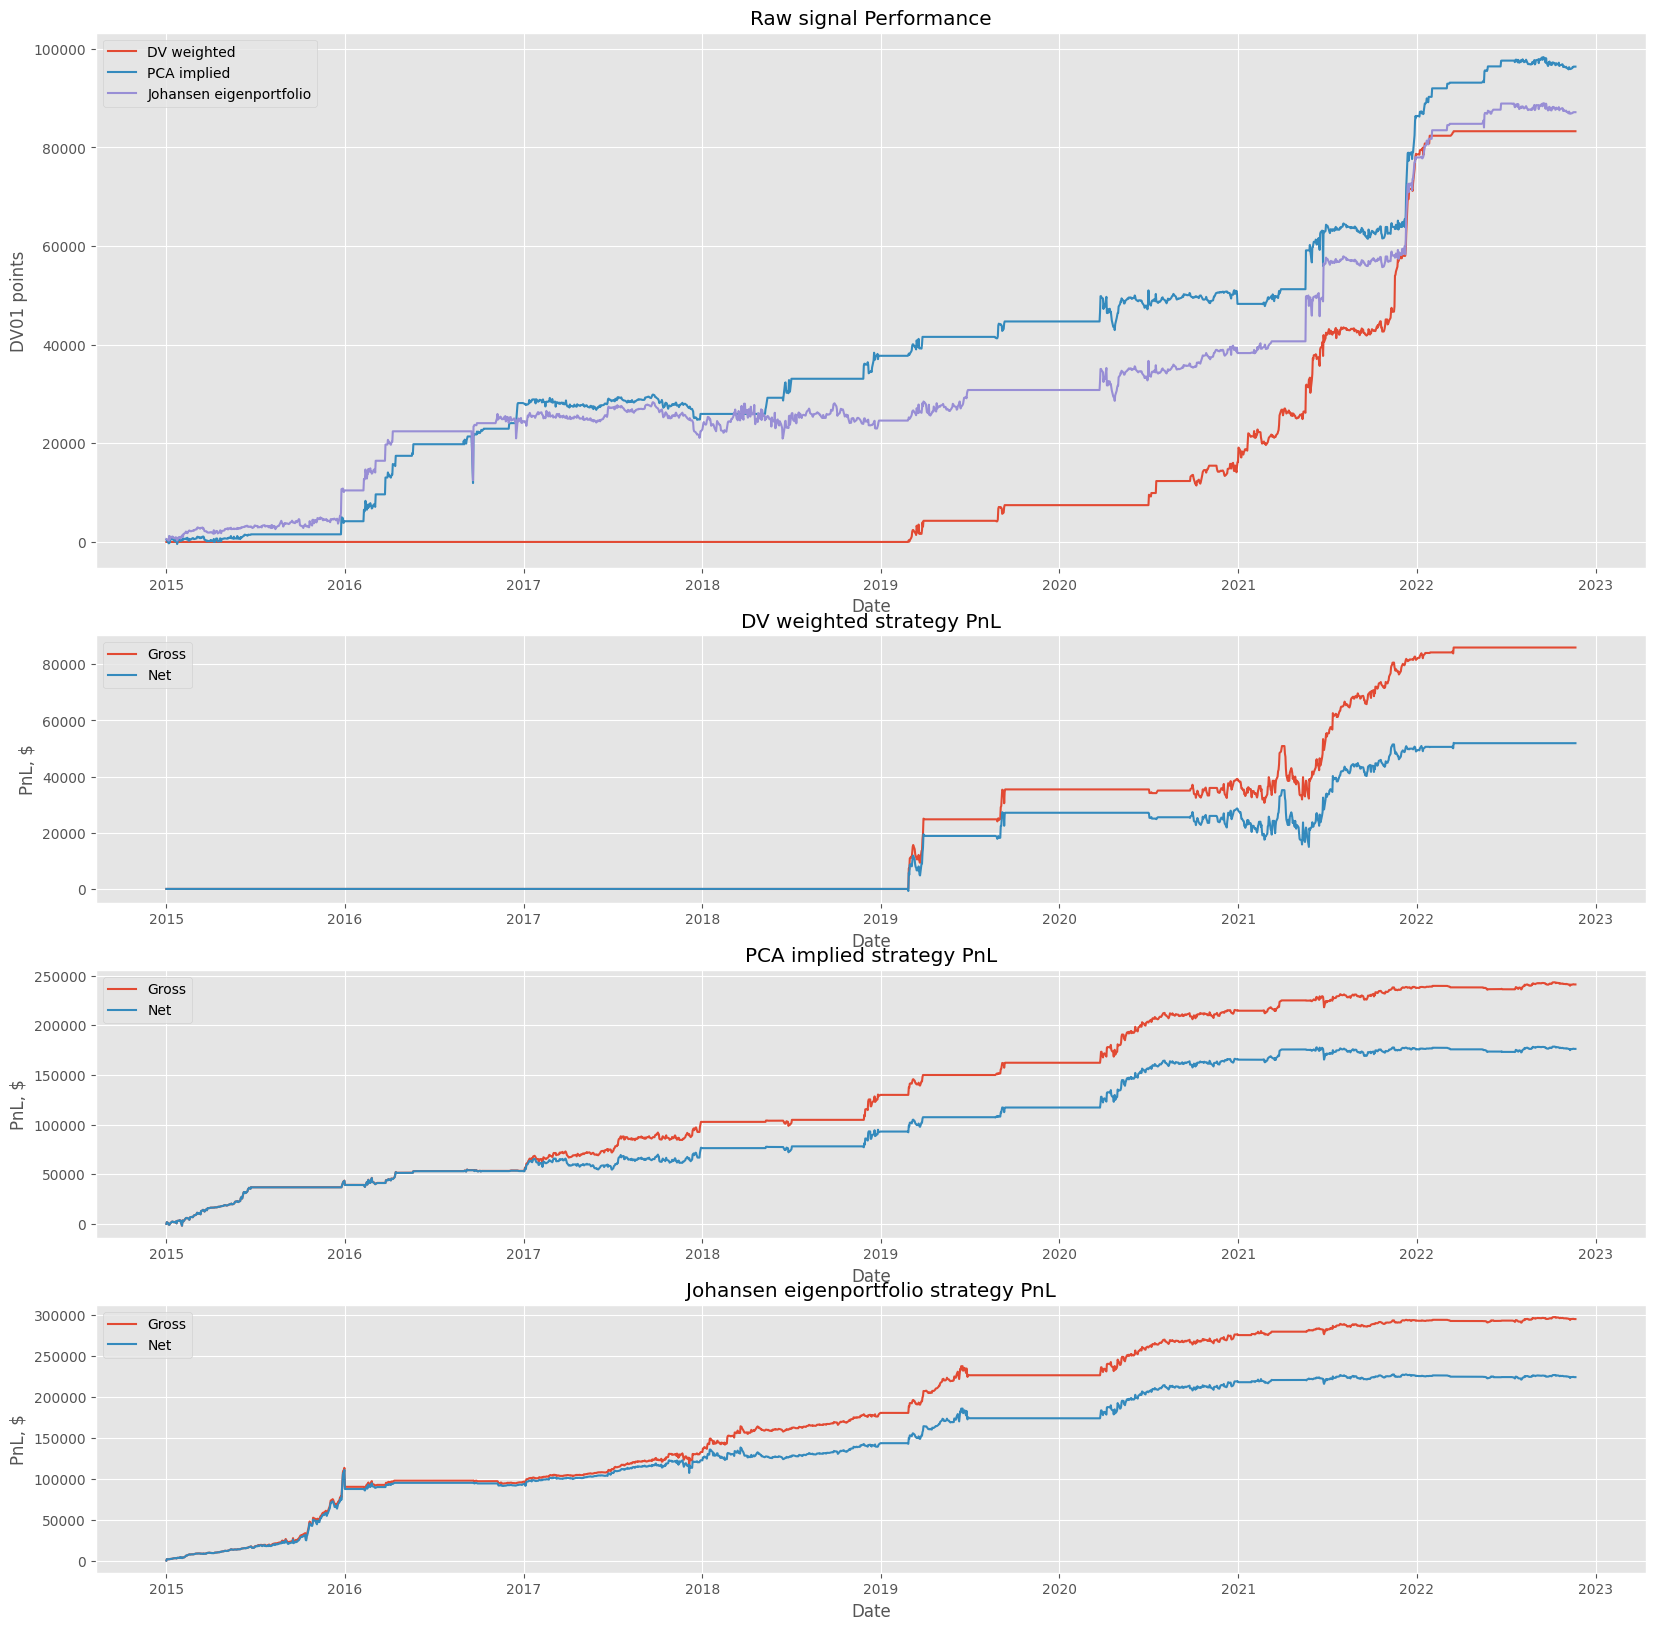

,Gross Sharpe,Net Sharpe,Daily Turnover
DV weighted,1.01,0.63,36.64%
PCA implied,1.77,1.32,42.38%
Johansen eigenportfolio,1.55,1.18,46.46%


In [27]:
cprint (('Aggregation of signals with volatility adjustment'.center(24)), 'green', attrs=['bold'])
signal_stats = signal_comparison(signals, signal_types, df_zc, df_instruments, df_prices, df_fit, vol_adjustment=True)
signal_stats.style.format({'Gross Sharpe': '{:.2f}', 'Net Sharpe': '{:.2f}', 'Daily Turnover': '{:.2%}'})    

In this case PCA looks slightly better overall although statistically Sharpe ratios for PCA and Johansen are probably indistinguishable on realistic sample size.